In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.feature import hog
from scipy.ndimage.measurements import label
from project_functions import *
# Read trained model by the Linear SVM
dist_pickle = pickle.load( open( "svc_model_best.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
color_space = dist_pickle["color_space"] 
orient = dist_pickle["orient"] # HOG orientations
pix_per_cell = dist_pickle["pix_per_cell"] # HOG pixels per cell
cell_per_block = dist_pickle["cell_per_block"] # HOG cells per block
spatial_size = dist_pickle["spatial_size"] # Spatial binning dimensions
hist_bins = dist_pickle["hist_bins"] # Number of histogram bins

In [4]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars1(img, ystart, ystop, xstart, xstop, scale, step, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)  - cell_per_block + 1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    #Create an empty list to receive positive detection windows
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            scale_temp = scale*(1+0*yb)
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #             test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            confidence_prediction = svc.decision_function(test_features)
            
            if confidence_prediction>1:
                xbox_left = np.int(xleft*scale_temp) + xstart
                ytop_draw = np.int(ytop*scale_temp)
                win_draw = np.int(window*scale_temp)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                # Append window position to list
                window_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return draw_img, window_list

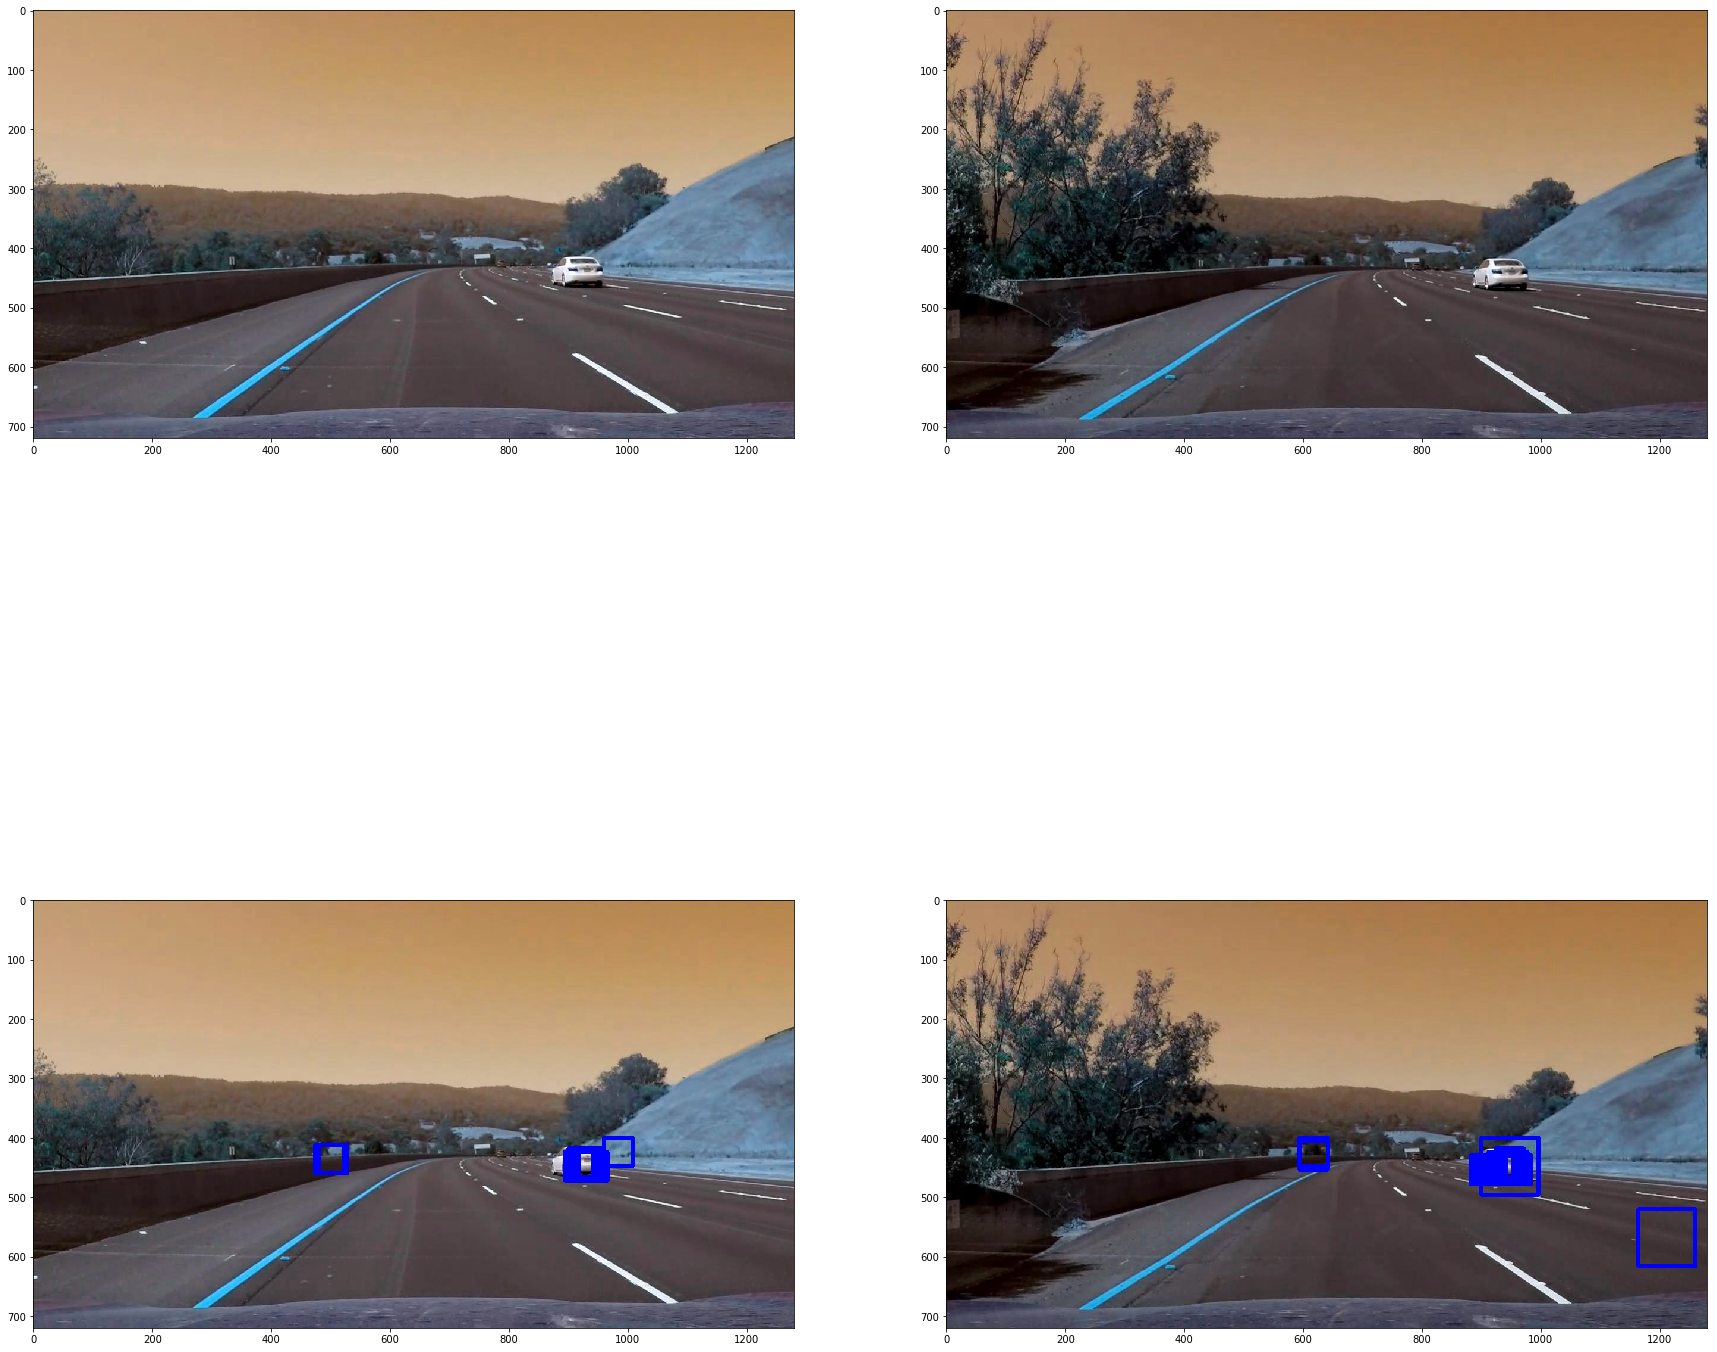

In [10]:
import math
import collections
boxes_track = collections.deque(maxlen=3)
heatmaps = collections.deque(maxlen=3)
heatmaps.clear()

# Define a function to draw bounding boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def Image_Process(image):
    
    background = np.zeros_like(image[:,:,0]).astype(np.float)
    
    boxes = []
    boxes = find_cars1(image, ystart=400, ystop=656, xstart=950, xstop=1280, scale=2.0, step=2, svc=svc, X_scaler=X_scaler, 
                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                  spatial_size=spatial_size, hist_bins=hist_bins)[1]
    boxes += find_cars1(image, ystart=400, ystop=500, xstart=950, xstop=1280, scale=1.5, step=2, svc=svc, X_scaler=X_scaler, 
                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                  spatial_size=spatial_size, hist_bins=hist_bins)[1]
    boxes += find_cars1(image, ystart=400, ystop=656, xstart=0, xstop=330, scale=1.5, step=2, svc=svc, X_scaler=X_scaler, 
                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                  spatial_size=spatial_size, hist_bins=hist_bins)[1]
    boxes += find_cars1(image, ystart=400, ystop=500, xstart=0, xstop=330, scale=1.5, step=2, svc=svc, X_scaler=X_scaler, 
                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                  spatial_size=spatial_size, hist_bins=hist_bins)[1]
    boxes += find_cars1(image, ystart=400, ystop=480, xstart=330, xstop=1200, scale=0.75, step=1, svc=svc, X_scaler=X_scaler, 
                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                  spatial_size=spatial_size, hist_bins=hist_bins)[1]
    boxes += find_cars1(image, ystart=400, ystop=656, xstart=900, xstop=1280, scale=1.5, step=2, svc=svc, X_scaler=X_scaler, 
                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                  spatial_size=spatial_size, hist_bins=hist_bins)[1]
    
    draw_img2 = draw_boxes(image, boxes)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold = 3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img1, bboxes1 = draw_labeled_bboxes(np.copy(image), labels)
    
    #
    heat2 =  add_heat(background,bboxes1)
    heatmaps.append(heat2)
    heatmap_sum = sum(heatmaps)
    heat_final = apply_threshold(heatmap_sum,threshold = 2)
    labels = label(heat_final)
    draw_img3, bboxes2 = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img3, draw_img2

image1 = cv2.imread('test_images/test10.jpg')
image2 = cv2.imread('test_images/test11.jpg')

# Plot the result
f = plt.figure(figsize=(30,30))
f.tight_layout()
plt.subplot(221)
plt.imshow(Image_Process(image1)[0])
plt.subplot(222)
plt.imshow(Image_Process(image2)[0])
plt.subplot(223)
plt.imshow(Image_Process(image1)[1])
plt.subplot(224)
plt.imshow(Image_Process(image2)[1])


In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
heatmaps.clear()
def Frame_Process(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(Image_Process(image)[0], cv2.COLOR_BGR2RGB)
Output = 'output_video.mp4'

##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
Clip = clip1.fl_image(Frame_Process) #NOTE: this function expects color images!!

Clip.write_videofile(Output, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [29:32<00:01,  1.40s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 



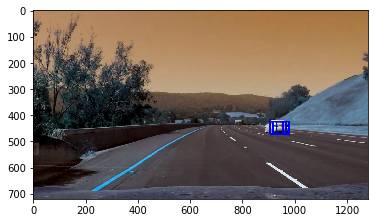

In [70]:
test_image = clip1.get_frame(6)
test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR)
plt.imshow(Image_Process(test_image)[1])
clip1.save_frame('test_images/test11.jpg',t=6)